
# **Sentiment Analysis of Amazon's customer reviews**

# Importing the packages for data analysis

In [ ]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

In [ ]:
amazon_reviews = pd.read_csv('/content/drive/MyDrive/Big_Data/final_assignment_bigdata/Customer_Reviews (1).txt')
amazon_reviews.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


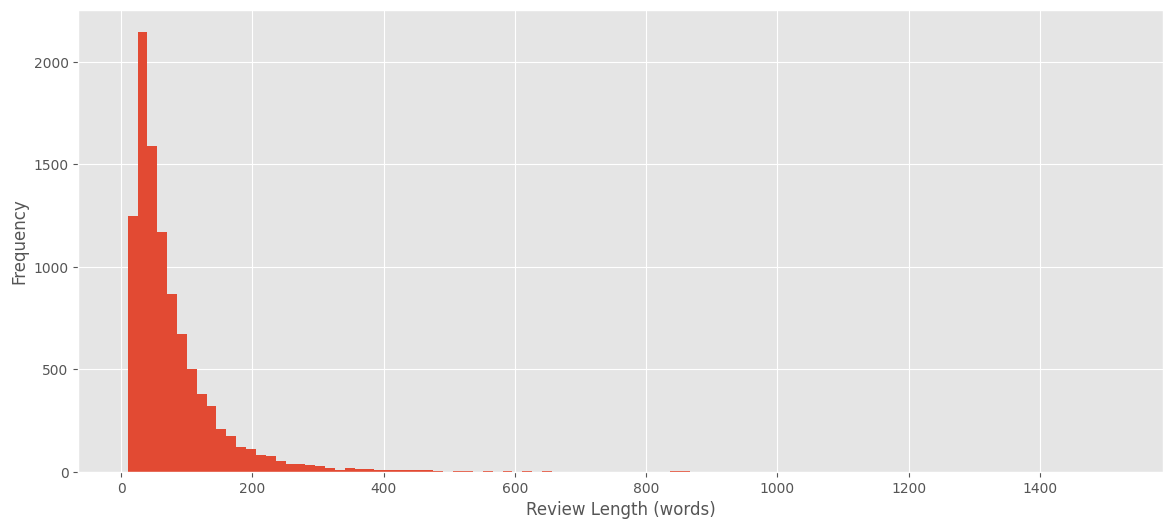

In [ ]:
## Getting the number of words by splitting them by a space
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


In [ ]:
percent_val = 100 * amazon_reviews['Score'].value_counts()/len(amazon_reviews)
percent_val

,count
Score,
5,61.83
4,14.33
1,9.32
3,8.62
2,5.90


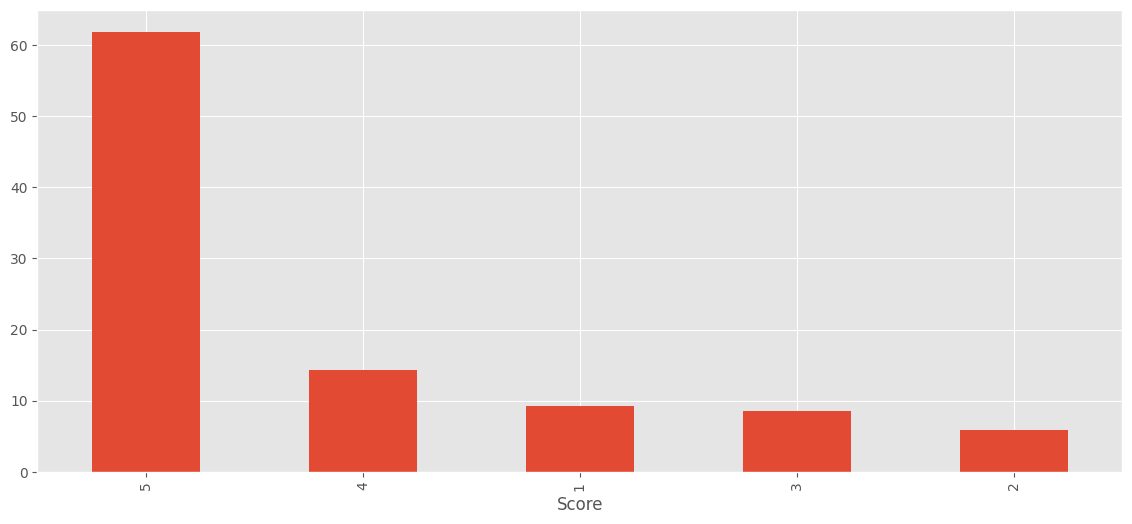

In [ ]:
percent_val.plot.bar()
plt.show()

# **Text visualization using word clouds (word clouds )**

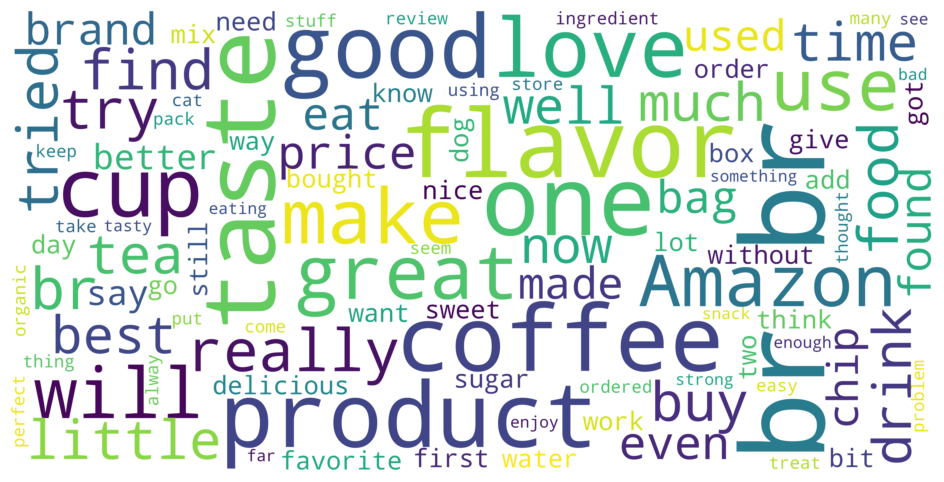

In [ ]:
word_cloud_text = ''.join(amazon_reviews['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

# Standardizing the ratings for sentiment analysis (5 mts)
For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule:

1.Ratings of 4 or 5 will get mapped to 1 and will be reltead to positive reviews

2.Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews

3.Ratings of 3 will get removed since they will represent neutral reviews.

In [ ]:
# Mapping the ratings
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)

## Removing neutral reviews
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

# Printing the counts of each class
amazon_reviews['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
1,7616
0,1522


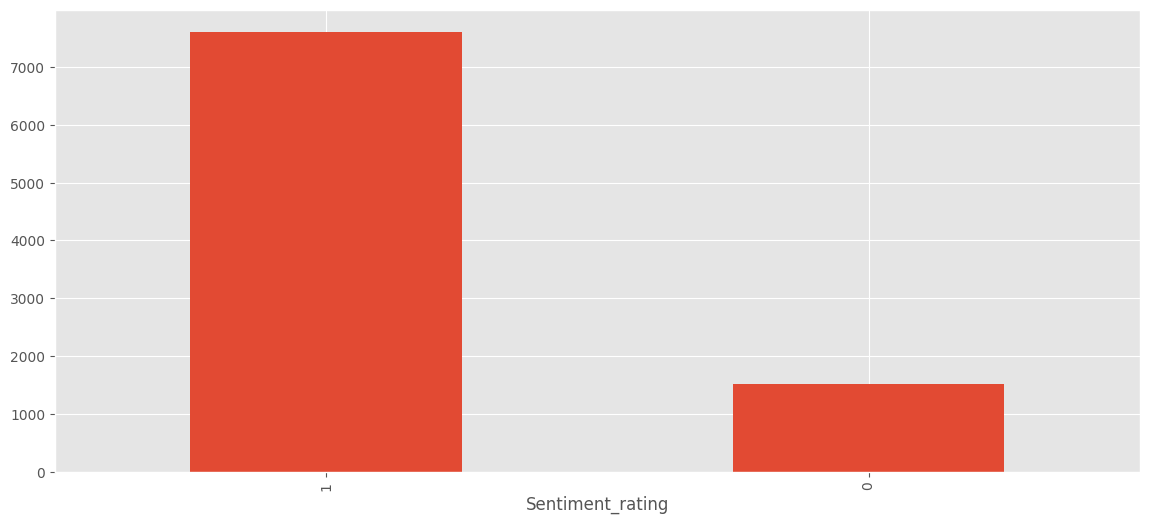

In [ ]:
amazon_reviews.Sentiment_rating.value_counts().plot.bar()
plt.show()

# Pre-processing

1.Converting words to lower/upper case

2.Removing special characters

3.Removing stopwords and high/low-frequency words
Stemming/lemmatization

1. Converting words to lower/upper case

In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews['Text'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step. This process of extracting individual words is called word tokenization, and can be run using the word_tokenize function in the nltk package:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('punkt_tab')  # Explicitly download the missing resource
nltk.download('punkt')      # Ensure punkt is also available

from nltk import word_tokenize
word_tokenize("DPhi Bootcamp rules. It is awesome :D")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['DPhi', 'Bootcamp', 'rules', '.', 'It', 'is', 'awesome', ':', 'D']

In [ ]:
# For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  27509
Number of unique tokens now:  22473


The number of tokens has gone down by ~18% just from normalizing the corpus.

Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like 'This product is the worst!!!', while a positive review could be like 'This product is the best. Loved it!'. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.

2. Removing special characters

In [ ]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_reviews['reviews_text_new'].apply(lambda review:
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

In [ ]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

Let's decomose the regular expression [^A-Za-z0-9 ]+:

[ ]: match any character inside the list defined by the square brackets, including the space character ' '
^: start of the line
A-Z: accept english upper case characters from A to Z
a-z: accept english lower case characters from a to z
0-9: accept single number characters from 0 to 9

In [ ]:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(amazon_reviews['reviews_text_new'][6])

- Old Review -
this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!

- New Review -
this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!


In [ ]:
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27509
Number of unique tokens now:  22473


# **3. Stopwords and high/low frequency words**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['albanian', 'arabic', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'tamil', 'turkish']


In [ ]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', '.', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', '.', 'labrador', 'finicky', 'appreciates', 'product', 'better', '.']


In [ ]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_reviews['reviews_text_nonstop'] = amazon_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, ., light, ,, p..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price. there was a wid...,"[great, taffy, great, price, ., wide, assortme..."
...,...,...
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,"like the bad reviews say, the organic formula ...","[like, bad, reviews, say, ,, organic, formula,..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, delieved, house, delievy, ch..."


# **4. Stemming & lemmatization**

**Stemming**: works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** :takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


It can be seen that we get a meaning root word from Lemmatizer while Stemmer just cuts out and extracts the first important part of the word.

Optionally and depending on the context and the nature of the problem, we can apply lemmatization and stemming to our dataset as follows:

In [ ]:
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]

amazon_reviews['reviews_text_stemm'] = amazon_reviews['reviews_text_nonstop'].apply(lambda row: stemm_terms(row))
amazon_reviews['reviews_text_lemm'] = amazon_reviews['reviews_text_nonstop'].apply(lambda row: lemmatize_terms(row))
amazon_reviews[['reviews_text_nonstop','reviews_text_stemm','reviews_text_lemm']]

,reviews_text_nonstop,reviews_text_stemm,reviews_text_lemm
0,"[bought, several, vitality, canned, dog, food,...","[bought, sev, vit, can, dog, food, produc, fou...","[bought, several, vitality, canned, dog, food,..."
1,"[product, arrived, labeled, jumbo, salted, pea...","[produc, ar, label, jumbo, salt, peanut, ..., ...","[product, arrived, labeled, jumbo, salted, pea..."
2,"[confection, around, centuries, ., light, ,, p...","[confect, around, century, ., light, ,, pillow...","[confection, around, century, ., light, ,, pil..."
3,"[looking, secret, ingredient, robitussin, beli...","[look, secret, ingredy, robitussin, believ, fo...","[looking, secret, ingredient, robitussin, beli..."
4,"[great, taffy, great, price, ., wide, assortme...","[gre, taffy, gre, pric, ., wid, assort, yummy,...","[great, taffy, great, price, ., wide, assortme..."
...,...,...,...
9995,"[switched, advance, similac, organic, product,...","[switch, adv, similac, org, produc, think, wou...","[switched, advance, similac, organic, product,..."
9996,"[like, bad, reviews, say, ,, organic, formula,...","[lik, bad, review, say, ,, org, formul, consti...","[like, bad, review, say, ,, organic, formula, ..."
9997,"[wanted, solely, breastfeed, unable, keep, sup...","[want, sol, breastfee, un, keep, suppl, formul...","[wanted, solely, breastfeed, unable, keep, sup..."
9998,"[love, fact, get, delieved, house, delievy, ch...","[lov, fact, get, deliev, hous, delievy, charge...","[love, fact, get, delieved, house, delievy, ch..."


# **Building a machine learning model**

In [ ]:
amazon_reviews[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


# **n-grams**

In [ ]:
from nltk import ngrams

sentence = 'A bird in the hand worths two in the bush'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


# **Bag-of-words**
The bag-of-words procedure falls under a broader category of techniques known as count-based representations. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

vec = CountVectorizer()
X = vec.fit_transform(amazon_reviews['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())  # Use get_feature_names_out()
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,...,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa,ît
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [ ]:
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 527075 stored elements and shape (9138, 22473)>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amazon_reviews['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [ ]:
y_test_bow.value_counts()/y_test_bow.shape[0]

,count
Sentiment_rating,
1,0.847921
0,0.152079


The test data contains 84% positive sentiment reviews. So, if we were to naively classify all reviews as positive, then our model would achieve an accuracy of 84%. Therefore, this is the baseline that any model we create must beat. We have an imbalance in the classes. However, we will skip the handling class imbalance processes to focus on NLP modeling. However, as an intermediate step, techniques such as SMOTE, sub-sampling or oversampling can be applied.

# **Applying logistic regression**

In [ ]:
### Training the model
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.9562719438238111


# Let's modify the set of features in the model to include bigrams, trigrams, and 4-grams:A

In [ ]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

In [ ]:
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2822625 stored elements and shape (9138, 1333543)>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    amazon_reviews['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [ ]:
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 score:  0.9558132246944532


The F1-score has jumped slightly. This is an example of what simple hyperparameter tuning and input feature modification can do to the overall performance. We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment:

In [ ]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(),  # Use get_feature_names_out() instead
                                   lr_model_all_new.coef_[0])),         # Logistic regression coefficients
                          columns=['words', 'weights'])                 # Column names

lr_weights.sort_values(['weights'], ascending=False)[:15]  # Top 15 most important features

,words,weights
551761,great,1.302665
414288,delicious,0.848758
542653,good,0.820289
1102317,the best,0.803734
910937,perfect,0.801890
737995,love,0.782864
464843,excellent,0.779399
295800,best,0.759563
811978,nice,0.750950
741249,loves,0.613028


In [ ]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

,words,weights
1045922,stick,-0.525813
270764,awful,-0.530719
425346,disappointing,-0.536878
269869,away,-0.539020
1314151,worst,-0.542099
1266852,waste,-0.551931
1278879,were,-0.562704
273091,bad,-0.653216
798325,n't,-0.656486
1274374,weak,-0.688665


# **TF-IDF model**

Of course, bag-of-words are not the only way to featurize text. Another method is the Term Frequency-Inverse Document Frequency (TF-IDF) method. This evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is the product of two terms. The first computes the normalized Term Frequency (TF); i.e. the number of times a word appears in a document divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears:

 re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [ ]:
tfidf_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 527075 stored elements and shape (9138, 22473)>

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_reviews['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

# Applying logistic regression to TF-IDF features

In [ ]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.9394584727715242


# **Conclusions**
In this case, we cleaned up and featurized an Amazon reviews dataset and built some classification models on these featurizations to predict sentiment. We saw that  TF-IDF both gave interpretable features. Through increase the set of n-grams we used from 1-grams to up to 4-grams, we were able to get our logistic regression model accuracy up to 95%.